# PREDICT SINE WAVE
The code provided uses the python package [keras 3.0](https://keras.io/api/) to construct and train an [artificial neural network](https://www.ibm.com/topics/neural-networks) (ANN) to learn a sine wave.

[Associated lecture slides HERE](https://docs.google.com/presentation/d/1VS2DZuPAQNnvKRNp0irmveNA_WaB1Ij1m5QkZ9PsmCs/edit?usp=sharing)

### Load Libraries

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import time
import keras
import sys
sys.path.append('../utils/')
from utils import make_fakedata, plot_datasplit, plot_performance, plot_prediction

# CREATE ANN FUNCTION:
`defineNN(hidden, input_shape, output_shape, ridge_penalty=0., lasso_penalty=0., act_fun='relu', network_seed=99)`


*  **hidden:** list of number of nodes in each hidden layer
*  **input_shape:** shape of a input (if input is a map, input_shape = nlat*nlon)
*   **output_shape:** shape of output
*   **ridge_penalty (L2 norm/regularization):** limits size of weights/attempts to evenly distribute weights
*  **lasso_penalty (L1):** limits size of weights/encorages insignificant weights to be 0
* **act_fun (activation function)**: nonlinear function applied to determine how much or whether a node should be activated


More notes:
> `inputs = keras.Input(...)`: create input layer \
> `keras.layers.Dense(...)`: creates a new layer \
> `model = keras.Model(...)`: makes the model




      


In [2]:
## >>>>> create neural network architecture >>>>>
def defineNN(hidden, input_shape, output_shape, ridge_penalty=0., lasso_penalty=0., act_fun='relu', network_seed=99):

    inputs = keras.Input(shape = input_shape)
    x = keras.layers.Dense(hidden[0],
                              activation = act_fun,
                              use_bias = True,
                              kernel_regularizer = keras.regularizers.l1_l2(l1=lasso_penalty, l2=ridge_penalty),
                              bias_initializer= keras.initializers.RandomNormal(seed=network_seed),
                              kernel_initializer= keras.initializers.RandomNormal(seed=network_seed)
                              )(inputs)

    #initialize hidden layers
    for layer in hidden[1:]:
        x = keras.layers.Dense(layer,
                                  activation = act_fun,
                                  use_bias = True,
                                  kernel_regularizer = keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                  bias_initializer = keras.initializers.RandomNormal(seed=network_seed),
                                  kernel_initializer = keras.initializers.RandomNormal(seed=network_seed)
                                  )(x)

    #initialize output layer
    output_layer = keras.layers.Dense(output_shape,
                                         activation = 'linear',
                                         use_bias = True,
                                         kernel_regularizer = keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                         bias_initializer = keras.initializers.RandomNormal(seed=network_seed),
                                         kernel_initializer = keras.initializers.RandomNormal(seed=network_seed)
                                         )(x)

    #create model
    model = keras.Model(inputs=inputs, outputs=output_layer)

    return model

# MAKE SOME FAKE DATA

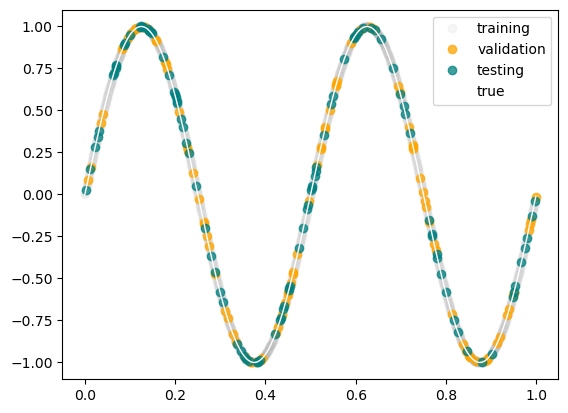

In [3]:
################################################################################
N_SAMPLES=1000
#fraction of data used for training (the rest is used split into validation and testing):
train_frac=0.8 
val_frac=0.1
test_frac=0.1
################################################################################
xtrue, ytrue, xtrain, ytrain, xval, yval, xtest, ytest = make_fakedata(N_SAMPLES,
                                                                       train_frac,
                                                                       val_frac,
                                                                       test_frac)

# Lets look at the data:
# white line: the function (all possible data points)
# grey dots: the data given to the neural network (training)
# teal dots: data withheld & used for evaluating neural network performance(testing)
plot_datasplit(xtrain, ytrain, xval, yval, xtest, ytest, xtrue, ytrue)

# TIME TO TRAIN

In [4]:
################################################################################
# set training parameters
ACT_FUNC = 'tanh' # activation function: sigmoid, relu, tanh
HIDDEN_LAYERS = [10,100] # hidden layers e.g. [10,20] means two hidden layers, 10 nodes connected to 20 nodes
BATCH_SIZE = 20 # batch size
LR = 0.001 # learning rate
N_EPOCHS = 10 # number of epochs

OPTIMIZER = 'adam' # optimizer [adam, SGD]
LOSS_FUNC = 'mae'  # loss function [mae, mse]
################################################################################

### Training Notes:
* `ann = defineNN(...)`: create model architecture to populate 
* `ann.compile(...)`: compile the model (specify loss function, optimizer, & metrics) 
* `ann.fit(...)`: train model 
* `ann.predict(...)`: make predictions with model


In [5]:
# ------ define NN ------
ann = defineNN(HIDDEN_LAYERS,
               input_shape=(1,),
               output_shape=1,
               act_fun=ACT_FUNC,
               )

# ------ Training Hyperparameters ------
if OPTIMIZER == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate = LR)
elif OPTIMIZER == 'SGD':
    optimizer = keras.optimizers.SGD(learning_rate = LR, momentum = 0.99)

if LOSS_FUNC == 'mae':
    loss_func = keras.losses.MeanAbsoluteError(name='mean_absolute_error')
elif LOSS_FUNC == 'mse':
    loss_func = keras.losses.MeanSquaredError(name='mean_squared_error')

metrics = [keras.losses.MeanAbsoluteError(name='mean_absolute_error'),
           keras.losses.MeanSquaredError(name='mean_squared_error')]

# ------ Compile Model -----
ann.compile(optimizer = optimizer,
            loss = loss_func,
            metrics = metrics)

# ------ Train -----
start_time = time.time()
history = ann.fit(xtrain, ytrain,
                  validation_data=[xval, yval],
                  batch_size=BATCH_SIZE,
                  epochs=N_EPOCHS,
                  shuffle=True,
                  verbose=2,
                  )
stop_time = time.time()
print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

Epoch 1/10


2025-10-15 12:09:29.065158: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


40/40 - 1s - 18ms/step - loss: 0.6472 - mean_absolute_error: 0.6472 - mean_squared_error: 0.5236 - val_loss: 0.6151 - val_mean_absolute_error: 0.6151 - val_mean_squared_error: 0.4851
Epoch 2/10
40/40 - 0s - 5ms/step - loss: 0.6307 - mean_absolute_error: 0.6307 - mean_squared_error: 0.4923 - val_loss: 0.5969 - val_mean_absolute_error: 0.5969 - val_mean_squared_error: 0.4578
Epoch 3/10
40/40 - 0s - 2ms/step - loss: 0.6106 - mean_absolute_error: 0.6106 - mean_squared_error: 0.4712 - val_loss: 0.5793 - val_mean_absolute_error: 0.5793 - val_mean_squared_error: 0.4280
Epoch 4/10
40/40 - 0s - 3ms/step - loss: 0.5841 - mean_absolute_error: 0.5841 - mean_squared_error: 0.4450 - val_loss: 0.5685 - val_mean_absolute_error: 0.5685 - val_mean_squared_error: 0.4179
Epoch 5/10
40/40 - 0s - 3ms/step - loss: 0.5736 - mean_absolute_error: 0.5736 - mean_squared_error: 0.4561 - val_loss: 0.5547 - val_mean_absolute_error: 0.5547 - val_mean_squared_error: 0.4034
Epoch 6/10
40/40 - 0s - 3ms/step - loss: 0.56

# LETS TAKE A LOOK
To check how well the network performed, we look at the loss values for the training and validation data

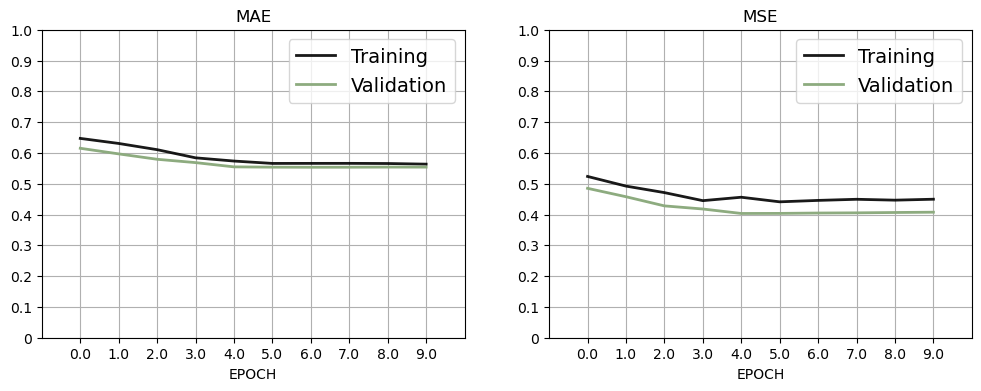

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


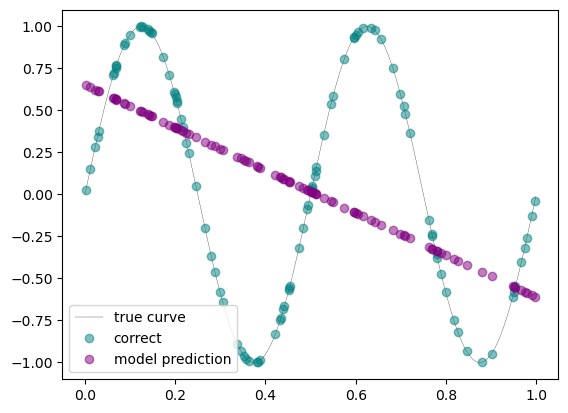

In [6]:
#---------- plot loss -------------------
plot_performance(m1_name='MAE',
                 m1=history.history['mean_absolute_error'], 
                 val_m1=history.history['val_mean_absolute_error'],
                 m2_name='MSE',
                 m2=history.history['mean_squared_error'],
                 val_m2=history.history['val_mean_squared_error'],
                 num_epochs=N_EPOCHS)

# Let's also plot the network's predictions compared to truth
pred = ann.predict(xtest)
plot_prediction(xtrue, ytrue, xtest, ytest, pred)

# Do NOT look past here... until I say so
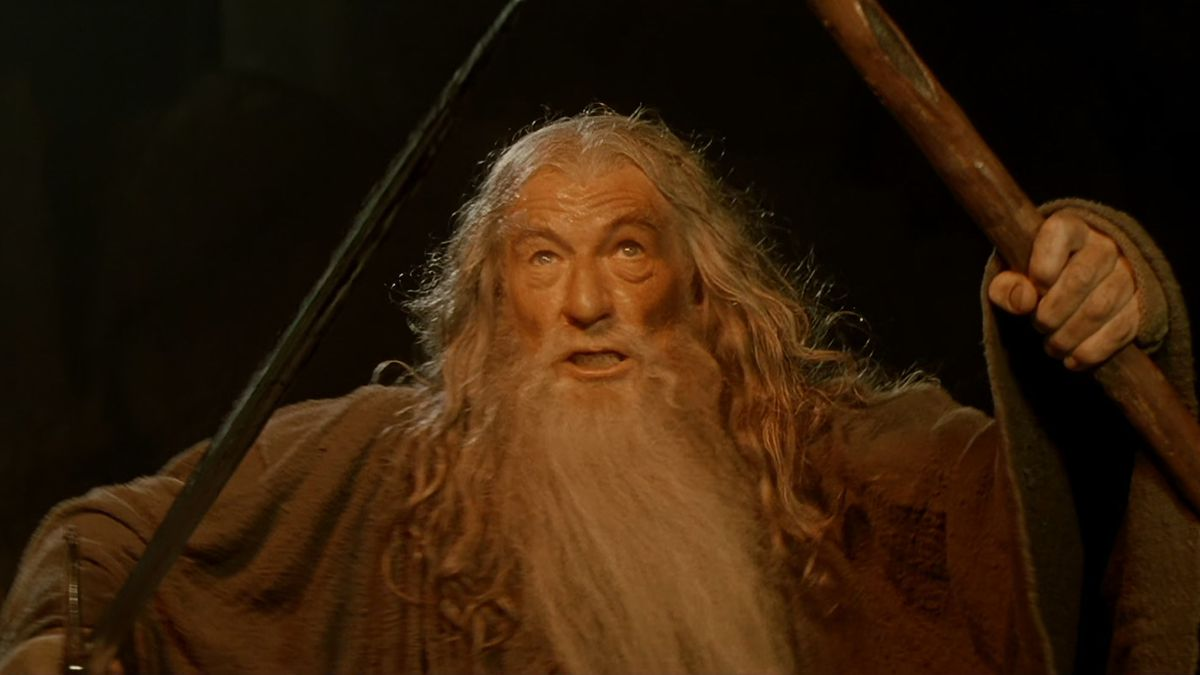

In [12]:
# set of training parameters that worked well for me
ACT_FUNC      = 'sigmoid' # activation function: sigmoid, relu, tanh
HIDDEN_LAYERS = [10,100]  # hidden layers
BATCH_SIZE    = 36        # batch size
LR            = 0.01      # learning rate
N_EPOCHS      = 1000      # number of epochs ---> then do 50 epochs! lets compare...

OPTIMIZER = 'adam' # optimizer [adam, SGD]
LOSS_FUNC = 'mae'  # loss function [mae, mse]